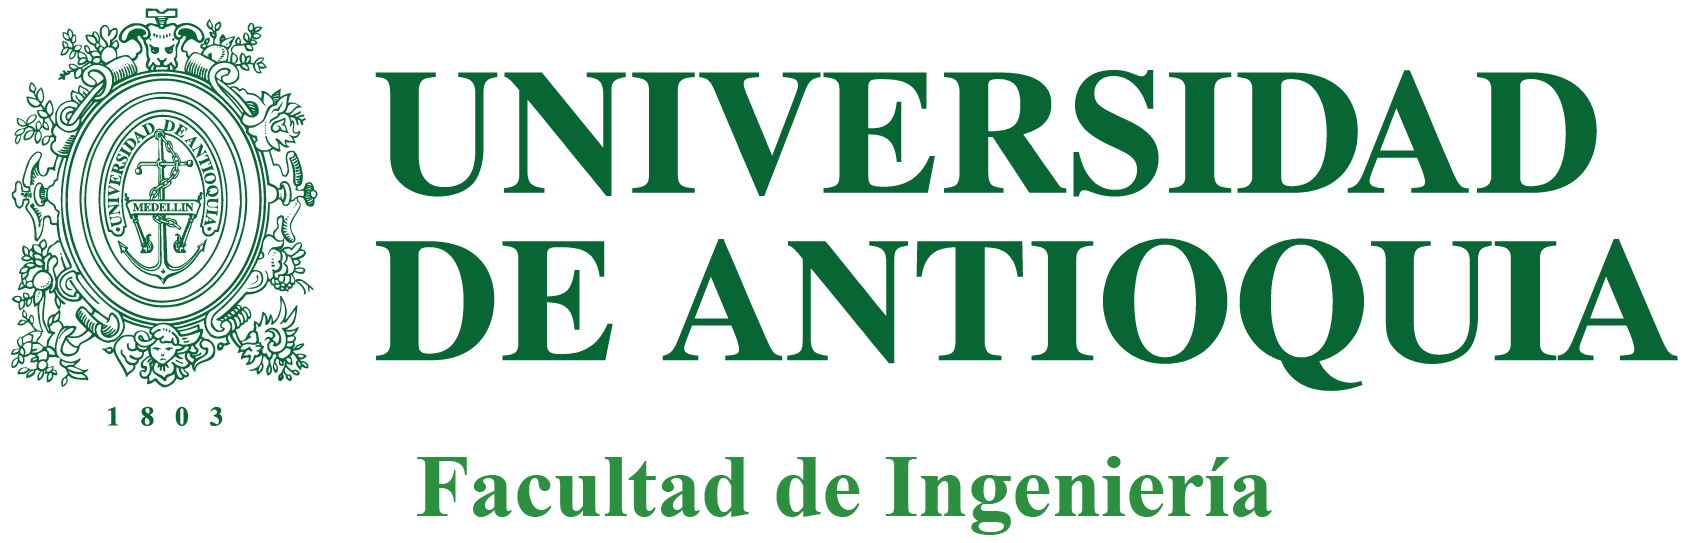


---------------
**Asignatura:** Tratamiento de Señales III

**Por:**

  - Juan Pablo Areiza
  - David Alexander Sánchez

**Profesor:** Hernán Felipe García Arias

**Facultad de Ingeniería**

**Departamento de Ingeniería Electrónica y Telecomunicaciones**

**Universidad de Antioquia**

**2023-2**

-------------
### Librerías

In [1]:
import os,random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle, sys
%matplotlib inline

-------------------
# Reconocimiento de modulación mediante redes neuronales convolucionales (CNN)

## 1. Preprocesamiento de datos:


In [2]:
!gdown '1Yuj_rq3EEITslOQ0AHEl2HKzDovMQH3K'

Downloading...
From: https://drive.google.com/uc?id=1Yuj_rq3EEITslOQ0AHEl2HKzDovMQH3K
To: /content/RML2016.10a_dict.pkl
100% 641M/641M [00:03<00:00, 203MB/s]


In [3]:
# Load the dataset ...
#  You will need to seperately download (radioml.com) or generate this file
with open("RML2016.10a_dict.pkl", 'rb') as f:
    Xd = pickle.load(f, encoding="latin1")

Los datos que se guardaron contenían una gran matriz de diccionario de Python. Las claves del diccionario fueron las combinaciones de tipo de [modulación](https://en.wikipedia.org/wiki/Phase-shift_keying) y relaciones señal-ruido (SNR) que fueron simuladas por GNU Radio para producir los datos. Hay 11 esquemas de modulación: 8 digitales y 3 analógicos. Se añadió ruido blanco gaussiano a cada señal proporcional a la potencia de la señal.

$$ \text{SNR in decibels} = 10 \times \log \left ( \frac{\text{signal power}}{\text{noise power}} \right ) $$

In [4]:
# Calculate modulations and signal-to-noise ratios contained in dataset
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])

In [5]:
print('These are the modulation schemes in the dataset: {}'.format(mods))
print('These are the signal to noise ratios in the dataset: {}'.format(snrs))

These are the modulation schemes in the dataset: ['8PSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM']
These are the signal to noise ratios in the dataset: [-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18]


### Señales de radiofrecuencia (RF)

Una vez que hayamos especificado la clave del diccionario (por ejemplo, ['QAM64', 4] para modulación QAM64 @ 4 dB SNR), nos quedará la siguiente matriz.

In [6]:
np.shape(Xd['BPSK', -18])

(1000, 2, 128)

+ La segunda dimensión representa los dos componentes ([I & Q](https://youtu.be/h_7d-m1ehoY)) de la señal de RF.
+ La tercera dimensión representa las 128 muestras en el tiempo (1 MHz, por lo que 1 $\mu$s por índice)
+ La primera dimensión representa las 1000 ventanas muestreadas (cada ventana tiene las 128 muestras I y Q)


$$\text{Modulated Carrier RF} = I \cos(2\pi ft) + Q \sin(2 \pi ft)$$

In [7]:
'''
Compute the original RF signal from the I & Q components.
'''
def reconstructSignal(s):
    I = s[0,:]   # I component
    Q = s[1,:]   # Q component
    n = len(I)   # number of samples
    f = 1e6     # Carrier frequency
    return I*np.cos(2*np.pi*f*np.arange(n)) + Q*np.sin(2*np.pi*f*np.arange(n))

### Tracemos algunos de los datos sin procesar.

Así que elegiremos un 8PSK (con SNR @ 18 dB), un PAM4 (con SNR @ 6 dB), un BPSK (con SNR @ 0 dB) y un QAM64 (con SNR @ -12 dB).

Observe cómo la señal queda enterrada en el ruido a medida que disminuye la SNR.

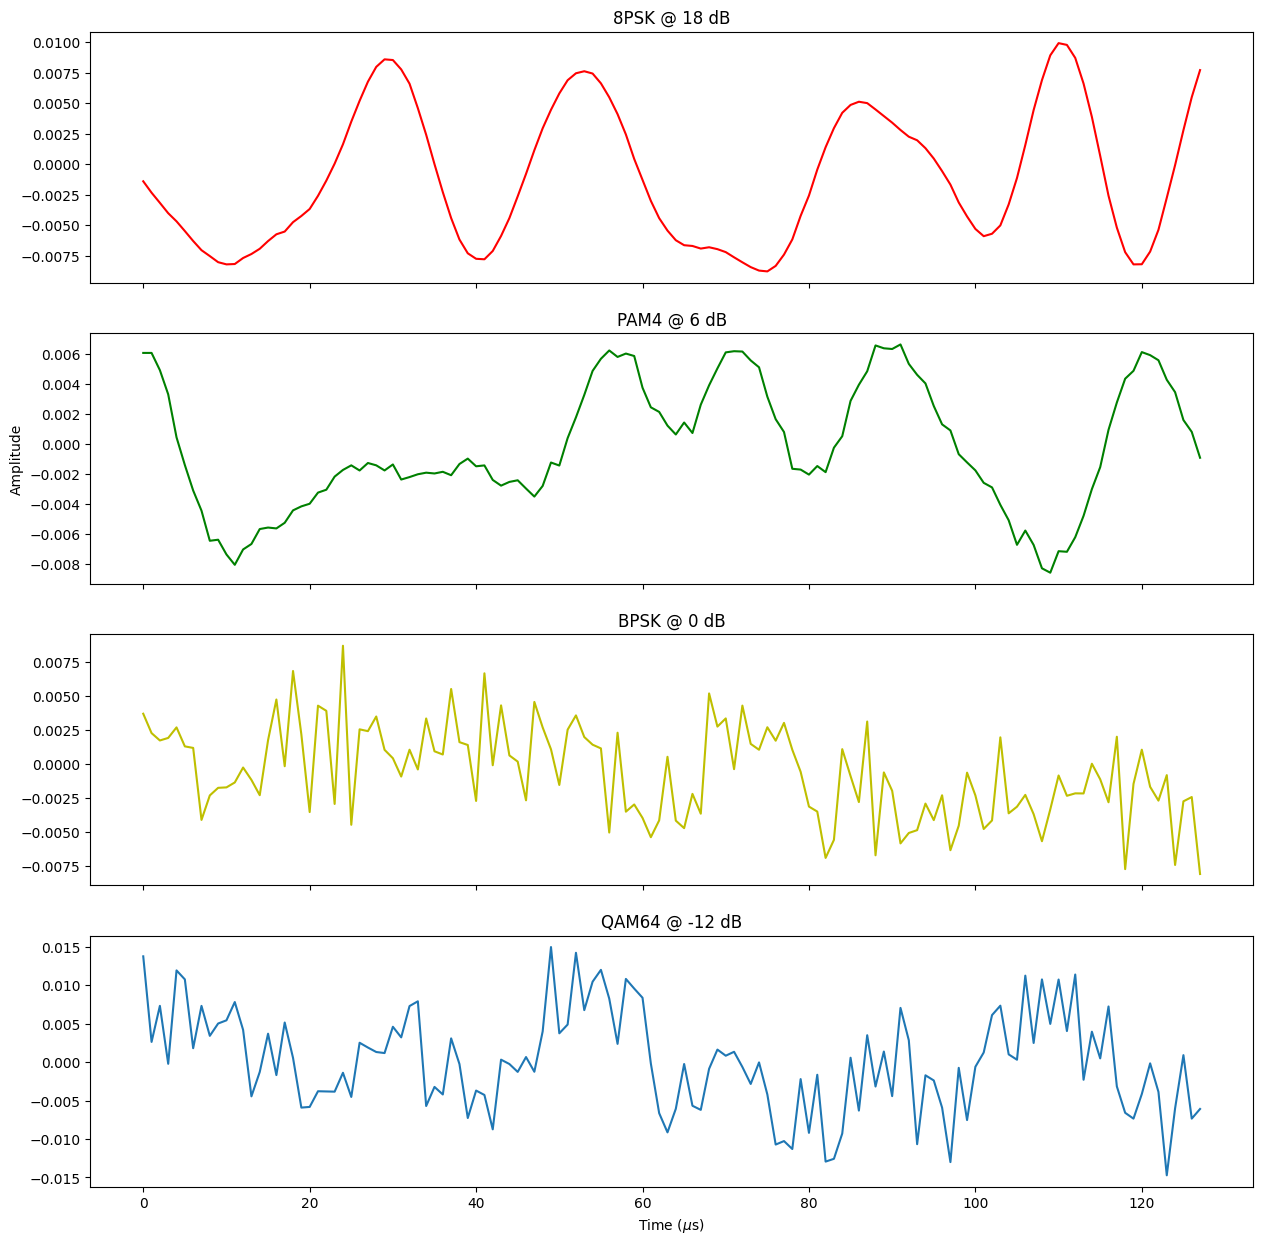

In [8]:
# Plot some of the data
nFigs = 4

plt.figure(figsize=(15, 15))

ax1 = plt.subplot(nFigs, 1, 1);
plt.plot(reconstructSignal(Xd['8PSK', 18][2,:,:]), color='r');
plt.title('8PSK @ 18 dB')

ax2 = plt.subplot(nFigs, 1, 2, sharex=ax1);
plt.plot(reconstructSignal(Xd['PAM4', 6][99,:,:]), color='g');
plt.title('PAM4 @ 6 dB')

plt.ylabel('Amplitude');

ax3 = plt.subplot(nFigs, 1, 3, sharex=ax1)
plt.plot(reconstructSignal(Xd['BPSK', 0][456,:,:]), color='y');
plt.title('BPSK @ 0 dB')

ax4 = plt.subplot(nFigs, 1, 4, sharex=ax1)
plt.plot(reconstructSignal(Xd['QAM64', -12][32,:,:]));
plt.title('QAM64 @ -12 dB')

# We only need to show the xticks on the bottom subplot
plt.setp(ax3.get_xticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)
plt.setp(ax1.get_xticklabels(), visible=False)

plt.xlabel(r'Time ($\mu$s)');

### Ahora necesitamos agregar toda la modulación, SNR, muestras, canales y puntos de tiempo en una gran matriz para pasar a nuestra red neuronal.

Entonces habrá 220.000 muestras. Cada muestra es de 2 x 128. Los 2 son los canales I y Q. Las 128 son las 128 muestras de tiempo de la forma de onda (muestreadas a 1 MHz).

In [9]:
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)

In [10]:
np.shape(X)

(220000, 2, 128)

### Agregar ruido al conjunto de datos

Agreguemos 2 canales de ruido gaussiano aleatorio para ver si podemos darle a la red la opción de elegir si no puede decidir entre las modulaciones verdaderas.

In [11]:
numNoiseSamples = 20000 # Add 20,000 samples of just Gaussian noise
for i in range(numNoiseSamples):
    lbl.append(['Noise', snrs[i%len(snrs)]])

mods.append('Noise')
X_noise = np.random.normal(0, 0.01, [numNoiseSamples, 2, 128])
X = np.concatenate((X, X_noise))  # Add noise to the end of the data

### Normalización

In [12]:
# Normalize each sample to range [0, 1]
X_normalized = (X - np.min(X, axis=2, keepdims=True)) / (np.max(X, axis=2, keepdims=True) - np.min(X, axis=2, keepdims=True))

### Reshape para la capa 2D convolucional

In [13]:
# Cambiar la forma de los datos para que sean compatibles con la CNN
# La CNN espera una entrada tridimensional (altura, anchura, canales)
# En este caso, los datos son bidimensionales, por lo que necesitamos agregar una dimensión extra
X_reshape = np.expand_dims(X_normalized, axis=-1)

In [14]:
print(X_reshape.shape)

(240000, 2, 128, 1)


## 2. Arquitectura del modelo CNN:


[Keras](https://keras.io/) es una abstracción de Python que le permite definir una red neuronal y codificarla automáticamente para bibliotecas de aprendizaje profundo (actualmente DeepLearning4j, TensorFlow y Theano). Simplemente le dice a Keras cuántas capas hay en el modelo de red y define cómo se ven esas capas. Keras se encarga de convertirlo en algo que TensorFlow y Theano puedan usar. Por lo tanto, es excelente para la experimentación de desarrollo rápido con redes neuronales. Puede construir cosas rápidamente y modificar rápidamente redes neuronales.

In [15]:
from tensorflow import keras
from keras.utils import to_categorical
import tensorflow.keras.models as models
from tensorflow.keras.layers import Reshape,Dense,Dropout,Activation,Flatten, BatchNormalization
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.regularizers import *
from keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
#from tensorflow.keras.optimizers import adam

CNN implemented

In [16]:
# Set dropout rate
dr = 0.5

# Define the model
model1 = models.Sequential()

# Reshape the input
model1.add(Reshape((2, 128, 1), input_shape=(2, 128)))

# Convolutional layers
model1.add(Conv2D(64, kernel_size=(2, 8), activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(1, 2)))

model1.add(Conv2D(128, kernel_size=(1, 8), activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(1, 2)))

model1.add(Conv2D(256, kernel_size=(1, 4), activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(1, 2)))

model1.add(Dropout(dr))
model1.add(Flatten())

# Fully connected layers
model1.add(Dense(512, activation='relu', kernel_regularizer=l2(0.01)))
model1.add(Dropout(dr))
model1.add(Dense(12, activation='softmax'))

# Print the model summary
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 2, 128, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 1, 121, 64)        1088      
                                                                 
 batch_normalization (Batch  (None, 1, 121, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 1, 60, 64)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 1, 53, 128)        65664     
                                                                 
 batch_normalization_1 (Bat  (None, 1, 53, 128)        5

In [78]:
# Set dropout rate
dr = 0.6

# Build the CNN model
model2 = models.Sequential()
model2.add(Reshape((2, 128, 1), input_shape=(2, 128)))

model2.add(Conv2D(16, kernel_size=(2, 8), strides=(1, 2), padding='valid', name='conv1', activation='relu'))
model2.add(Conv2D(32, kernel_size=(1, 3), strides=(1, 2), padding='valid', name='conv2', activation='relu'))
model2.add(Conv2D(64, kernel_size=(1, 3), strides=(1, 2), padding='valid', name='conv3', activation='relu'))

model2.add(Flatten())

model2.add(Dense(512, name='dense1', activation='relu', kernel_regularizer=l2(0.001)))
model2.add(Dropout(dr, name='dropout_1'))
model2.add(Dense(256, name='dense2', activation='relu', kernel_regularizer=l2(0.001)))
model2.add(Dropout(dr, name='dropout_2'))
model2.add(Dense(12, name='dense3'))
model2.add(Activation('softmax', name='activation_1'))

model2.add(Reshape((12,)))

model2.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_12 (Reshape)        (None, 2, 128, 1)         0         
                                                                 
 conv1 (Conv2D)              (None, 1, 61, 16)         272       
                                                                 
 conv2 (Conv2D)              (None, 1, 30, 32)         1568      
                                                                 
 conv3 (Conv2D)              (None, 1, 14, 64)         6208      
                                                                 
 flatten_9 (Flatten)         (None, 896)               0         
                                                                 
 dense1 (Dense)              (None, 512)               459264    
                                                                 
 dropout_1 (Dropout)         (None, 512)              

In [79]:
model1.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

model2.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

## 3. Entrenamiento:


### Ahora dividamos aleatoriamente el conjunto de datos en un grupo de entrenamiento y un grupo de prueba.

El grupo de entrenamiento se utilizará para calcular los pesos de la red neuronal. El grupo de prueba se utilizará para evaluar (validar) qué tan bien se generalizan esos pesos a nuevos datos (es decir, qué tan bien debería funcionar nuestra red neuronal en la naturaleza).

Nuestro primer paso es [One Hot Encode](https://en.wikipedia.org/wiki/One-hot). Suena mal, pero es un procedimiento realmente sencillo. Básicamente, la computadora no entiende letras; sólo puede utilizar números. Por lo tanto, no tiene idea de a qué se refieren '8PSK' o 'WBFM' y no tiene forma de entrenar un modelo para que se ajuste a esas etiquetas. Ahora podríamos simplemente asignar un número a cada modulación (por ejemplo, 1 = '8PSK', 2 = 'AM-DSB', 3 = 'PAM4', etc.). Sin embargo, la codificación one-hot nos facilita calcular qué tan cerca está la salida de nuestra red neuronal (es decir, la predicción) del valor verdadero (esperado).

Para la codificación one-hot simplemente declaramos un vector que es tan grande como el conjunto de modulaciones únicas. Entonces, si tenemos 11 modulaciones, declaramos un vector de tamaño 1 x 11. La matriz es 0 en todas partes excepto en la modulación que se representa. Por ejemplo,

+  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] codes '8PSK'
+  [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0] codes 'AM-DSB'
+  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] codes 'WBFM'
  
Entonces, el elemento más a la izquierda codifica '8PSK' y el más a la derecha codifica 'WBFM'. El posicionamiento es arbitrario. Simplemente tiene que aplicarse de forma coherente al conjunto de datos.

Una vez que hayamos codificado One Hot, podremos comparar qué tan cerca llega la salida de nuestra red neuronal (es decir, la predicción) a la modulación verdadera. Esta medida de "cercanía" se calcula normalmente mediante entropía cruzada (Shannon). Hay un excelente [video aquí] (https://www.youtube.com/watch?v=tRsSi_sqXjI).

$$ \text{cross entropy} = - \sum_i{L_i \log{S_i}}$$

dónde
+ $i$ pasa de 1 al número de modulaciones
+ $L_i$ es la etiqueta única para esa muestra en esa modulación
+ $S_i$ es la predicción de la red neuronal para esa muestra en esa modulación

Por ejemplo, si nuestra red neuronal predice 3 clases con las siguientes probabilidades:

$$\begin{bmatrix}0.2\\0.7\\0.1 \end{bmatrix}$$

y la muestra real tiene la codificación one-hot de:

$$\begin{bmatrix}0\\1\\0\end{bmatrix}$$

Entonces nuestra entropía cruzada es:
$$ - [ 0 \times \log(0.2) + 1 \times \log(0.7) + 0 \times \log(0.1) ] = \log(0.7) = 0.155$$

Si la predicción es perfecta, entonces la entropía cruzada es $1 \times \log(1) = 0$

In [56]:
from sklearn.preprocessing import LabelBinarizer

lbl = np.array(lbl) # Convert from list to numpy array (for speed)

# This will encode the labels into a binary array.
# This is referred to as One-Hot.
# Each element of the array is either 1 or 0.
# The position of the element refers to which type of modulation.
# So if there are 11 modulation types, then the
# array is length 11.
# e.g.  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] codes '8PSK'
#       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0] codes 'AM-DSB'
#       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] codes 'WBFM'
# We'll use this to compare the output of the neural network
# and help train the model to give the lowest error (in this case
# the cost will be the cross-entropy).
y_encoded = LabelBinarizer().fit_transform(lbl[:,0])

print(y_encoded.shape)

(240000, 12)


In [57]:
y_encoded[-10:]

array([[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]])

### Dividir en un conjunto de entrenamiento y prueba



In [58]:
# Partition the data
#  into training and test sets of the form we can train/test on
#  while keeping SNR and Mod labels handy for each
np.random.seed(2016)
n_examples = X.shape[0]
n_train = int(n_examples * 0.7)

# Now get a list of random indicies to sample for the training set
train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)

# Testing set is whatever indicies are left over
test_idx = list(set(range(0,n_examples))-set(train_idx))

# Now split up the data by the random indicies
X_train = X[train_idx]
X_test =  X[test_idx]
Y_train = y_encoded[train_idx]
Y_test = y_encoded[test_idx]

In [59]:
print('Training set is {}'.format(np.shape(X_train)))
print('Test set is {}'.format(np.shape(X_test)))

Training set is (168000, 2, 128)
Test set is (72000, 2, 128)


In [60]:
in_shp = list(X_train.shape[1:])   # This is the input shape of 2 channels x 128 time samples
print(X_train.shape, in_shp)
classes = mods
print(classes)

(168000, 2, 128) [2, 128]
['8PSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM', 'Noise']


### Entrenar el modelo

`ModelCheckpoint` y `EarlyStopping` se utilizan para monitorear el entrenamiento y evitar el sobreajuste

In [61]:
# Set up some params
nb_epoch = 200     # number of epochs to train on
batch_size = 1024  # training batch size

In [87]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = './'
modelWeightsFile = filepath + 'PESOS_TSIII.wts.h5'  # Save the model weights to this file

history = model1.fit(X_train,
    Y_train,
    batch_size=batch_size,
    epochs=nb_epoch,
    verbose=2,
    validation_data=(X_test, Y_test),
    callbacks = [
        keras.callbacks.ModelCheckpoint(modelWeightsFile, monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
    ])

# we re-load the best weights once training is finished
model1.load_weights(modelWeightsFile)

Epoch 1/200

Epoch 1: val_loss improved from inf to 4.31142, saving model to ./PESOS_TSIII.wts.h5
165/165 - 10s - loss: 4.7489 - accuracy: 0.4145 - val_loss: 4.3114 - val_accuracy: 0.0828 - 10s/epoch - 63ms/step
Epoch 2/200


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss did not improve from 4.31142
165/165 - 6s - loss: 1.4888 - accuracy: 0.5256 - val_loss: 4.7435 - val_accuracy: 0.0828 - 6s/epoch - 38ms/step
Epoch 3/200

Epoch 3: val_loss improved from 4.31142 to 3.68173, saving model to ./PESOS_TSIII.wts.h5
165/165 - 6s - loss: 1.3996 - accuracy: 0.5389 - val_loss: 3.6817 - val_accuracy: 0.1267 - 6s/epoch - 39ms/step
Epoch 4/200

Epoch 4: val_loss improved from 3.68173 to 2.60837, saving model to ./PESOS_TSIII.wts.h5
165/165 - 6s - loss: 1.3775 - accuracy: 0.5478 - val_loss: 2.6084 - val_accuracy: 0.2396 - 6s/epoch - 39ms/step
Epoch 5/200

Epoch 5: val_loss improved from 2.60837 to 1.33335, saving model to ./PESOS_TSIII.wts.h5
165/165 - 6s - loss: 1.3445 - accuracy: 0.5558 - val_loss: 1.3333 - val_accuracy: 0.5574 - 6s/epoch - 39ms/step
Epoch 6/200

Epoch 6: val_loss did not improve from 1.33335
165/165 - 7s - loss: 1.3335 - accuracy: 0.5607 - val_loss: 1.4192 - val_accuracy: 0.5285 - 7s/epoch - 43ms/step
Epoch 7/200

Epoch 7: val_

## 4. Evaluación:


In [88]:
from sklearn.metrics import classification_report
import pandas as pd

# Use the model to predict
y_pred = model1.predict(X_test)

# Convert predictions classes to one-hot vectors
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert validation observations to one-hot vectors
y_true = np.argmax(Y_test, axis=1)

# Use sklearn to compute accuracy and confusion matrix
class_report = classification_report(y_true, y_pred_classes, target_names=classes, output_dict=True)

# Convert the classification report to a pandas DataFrame
df = pd.DataFrame(class_report).transpose()

# Print the DataFrame
print(df)

2250/2250 [==============================] - 6s 3ms/step
              precision    recall  f1-score      support
8PSK           0.737645  0.511163  0.603867   5957.00000
AM-DSB         0.444112  0.609023  0.513656   5852.00000
AM-SSB         0.253050  0.923129  0.397215   5932.00000
BPSK           0.845937  0.595274  0.698807   6051.00000
CPFSK          0.924057  0.595841  0.724511   5963.00000
GFSK           0.755263  0.637496  0.691400   6022.00000
PAM4           1.000000  1.000000  1.000000   6125.00000
QAM16          0.925214  0.667001  0.775170   5991.00000
QAM64          0.457050  0.143244  0.218126   5906.00000
QPSK           0.541295  0.604412  0.571115   6029.00000
WBFM           0.860507  0.469368  0.607417   6072.00000
Noise          0.609247  0.267869  0.372125   6100.00000
accuracy       0.585750  0.585750  0.585750      0.58575
macro avg      0.696115  0.585318  0.597784  72000.00000
weighted avg   0.697826  0.585750  0.599035  72000.00000


## 5. Visualización:


### Curvas de pérdida

Las curvas de pérdidas nos muestran qué tan bien fue el entrenamiento. También nos permiten detectar el sobreentrenamiento del modelo. Si el modelo está sobreentrenado, es posible que no se generalice bien. A menudo, en un modelo sobreentrenado, la pérdida de entrenamiento (error) disminuirá continuamente mientras que la validación (error de prueba) disminuirá y luego comenzará a aumentar nuevamente con sucesivas épocas de entrenamiento.

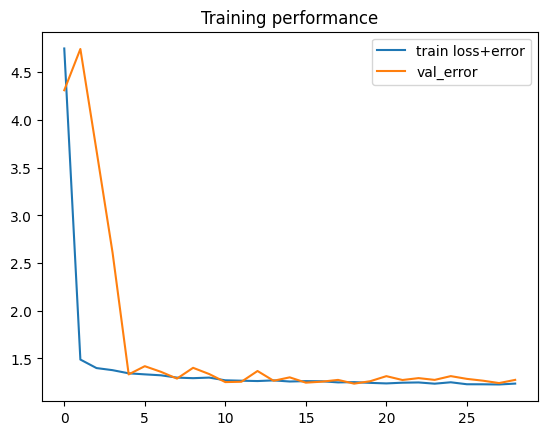

In [89]:
# Show loss curves
plt.figure();
plt.title('Training performance');
plt.plot(history.epoch, history.history['loss'], label='train loss+error');
plt.plot(history.epoch, history.history['val_loss'], label='val_error');
plt.legend();

### Matriz de confusión

Una matriz de confusión es una excelente manera de ver dónde tuvo problemas el modelo (red neuronal). Traza el número de veces que el modelo predijo una modulación versus la modulación real (predicha versus verdadera).

In [90]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

71/71 [==============================] - 1s 13ms/step


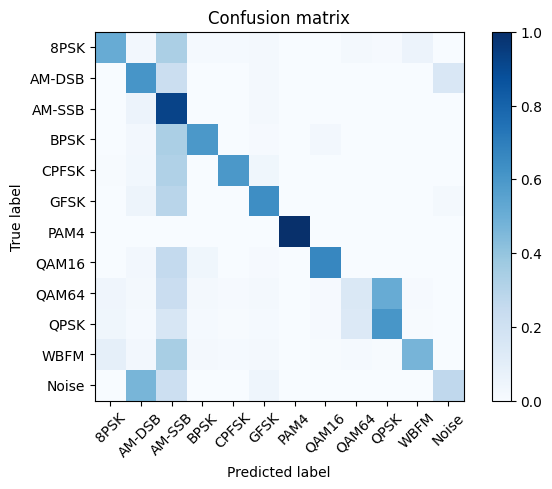

In [92]:
# Plot confusion matrix
test_Y_hat = model1.predict(X_test, batch_size=batch_size)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)

Evaluación del modelo en términos de $SNR$ y su precisión para cada modulación

4/4 [==============================] - 0s 13ms/step
Overall Accuracy for SNR -20: 0.16680637049455155
4/4 [==============================] - 0s 11ms/step
Overall Accuracy for SNR -18: 0.1786208806424813
4/4 [==============================] - 0s 13ms/step
Overall Accuracy for SNR -16: 0.17545777534845586
4/4 [==============================] - 0s 16ms/step
Overall Accuracy for SNR -14: 0.18763796909492272
4/4 [==============================] - 0s 16ms/step
Overall Accuracy for SNR -12: 0.2160460021905805
4/4 [==============================] - 0s 15ms/step
Overall Accuracy for SNR -10: 0.2674986435160065
4/4 [==============================] - 0s 13ms/step
Overall Accuracy for SNR -8: 0.38903025162567145
4/4 [==============================] - 0s 12ms/step
Overall Accuracy for SNR -6: 0.5295270081164287
4/4 [==============================] - 0s 11ms/step
Overall Accuracy for SNR -4: 0.648618476137315
4/4 [==============================] - 0s 12ms/step
Overall Accuracy for SNR -2: 0.73965802

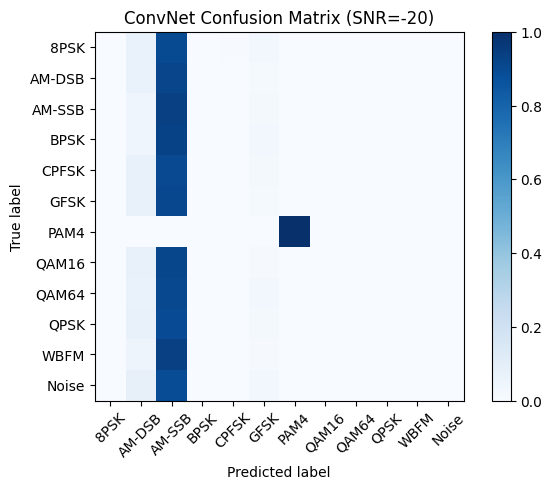

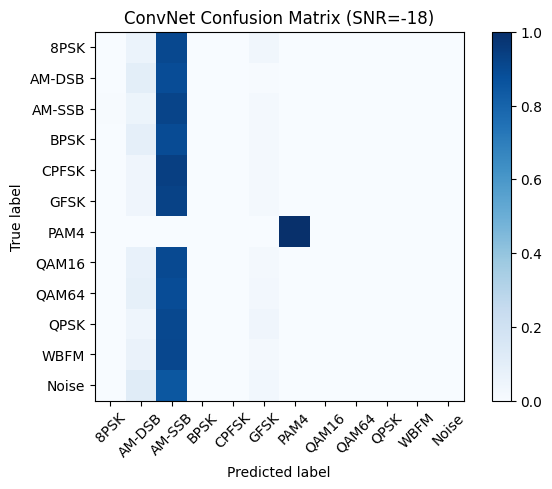

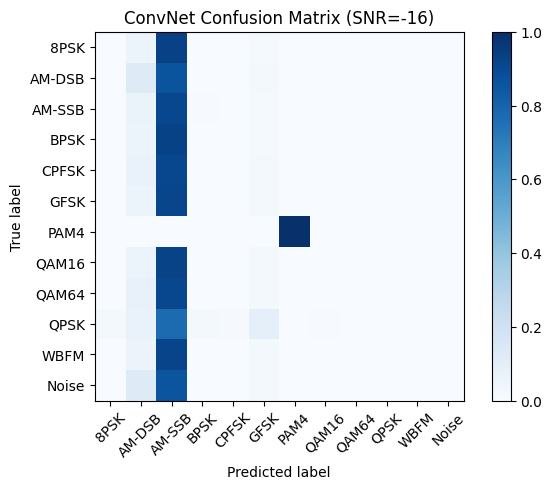

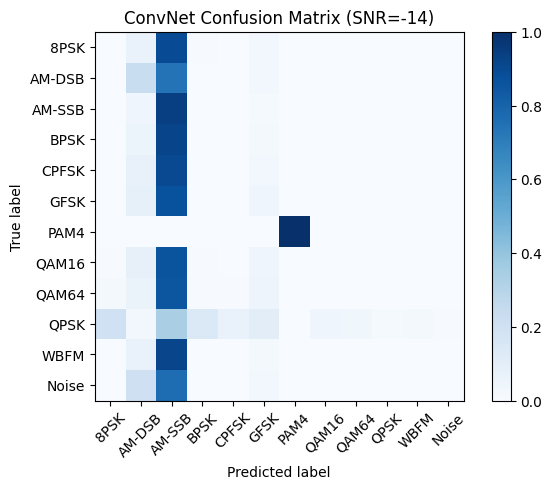

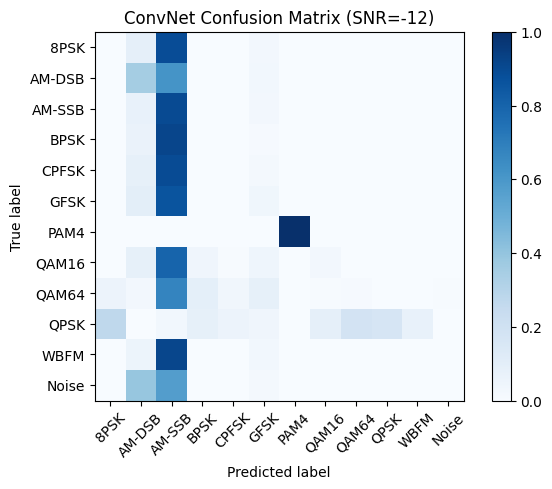

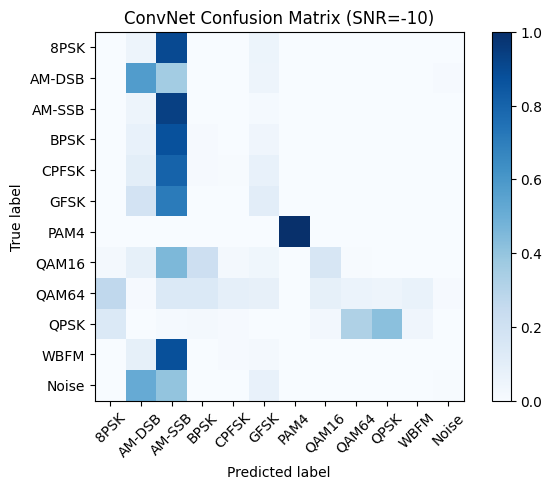

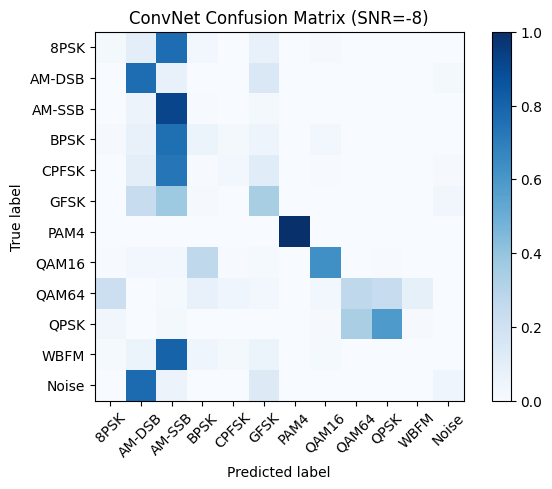

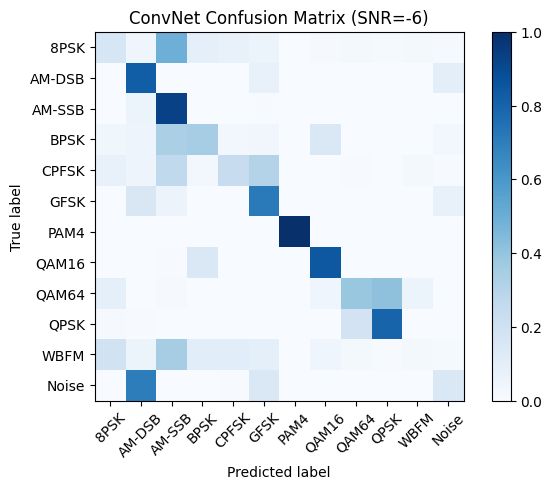

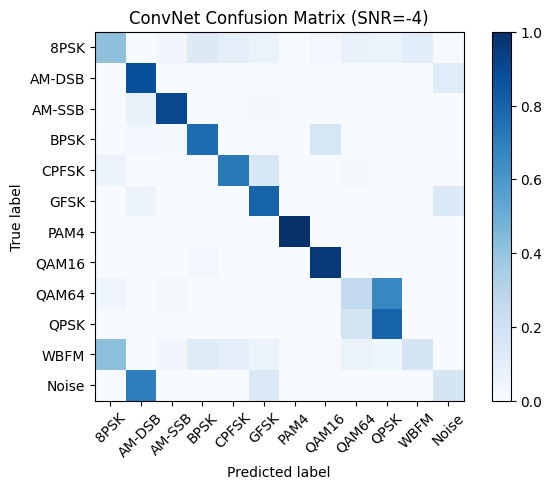

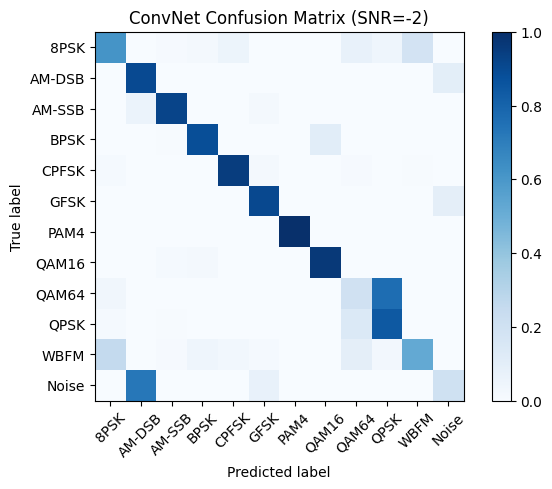

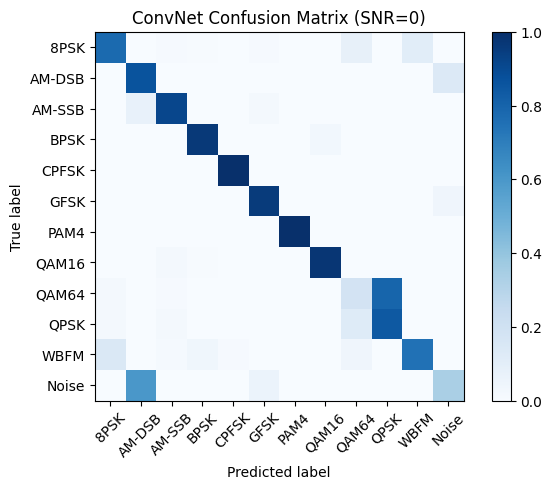

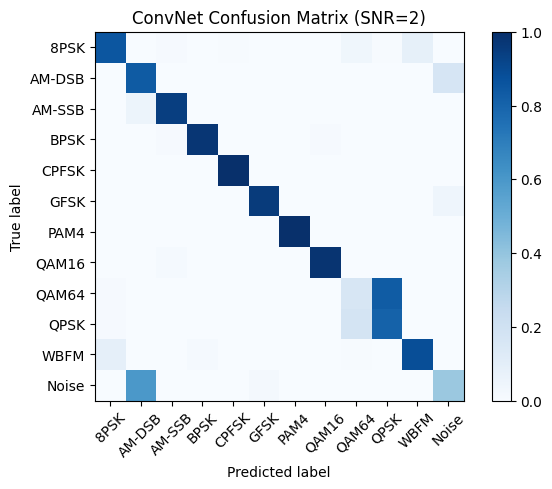

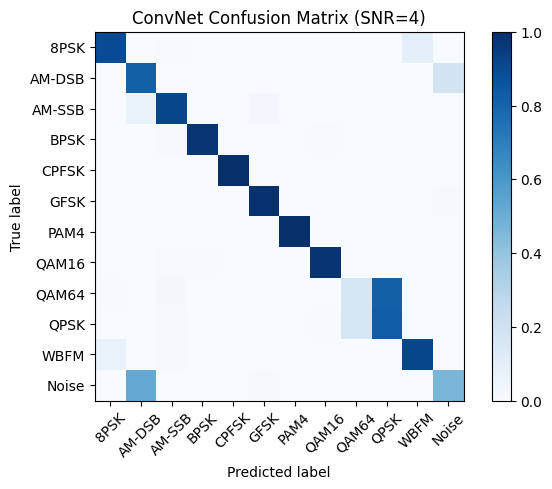

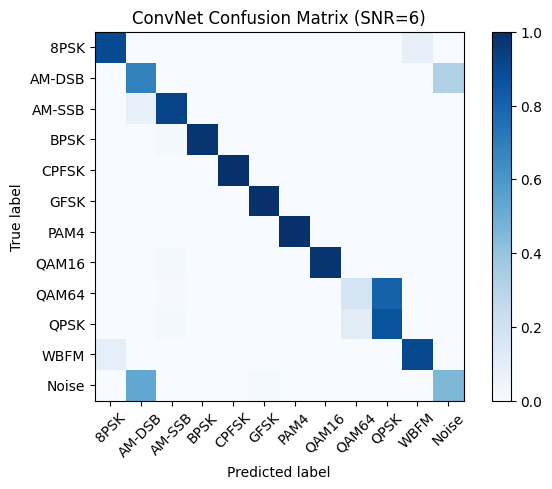

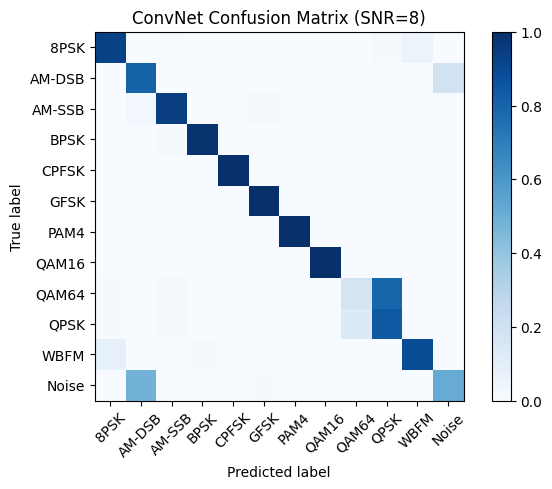

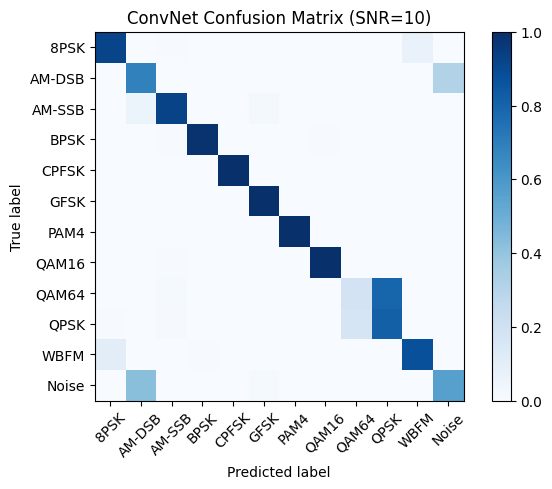

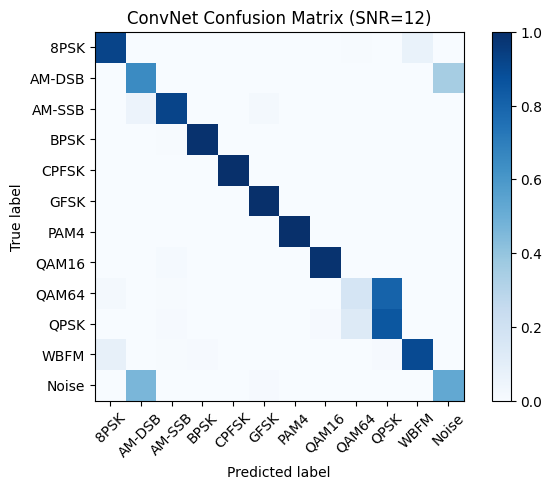

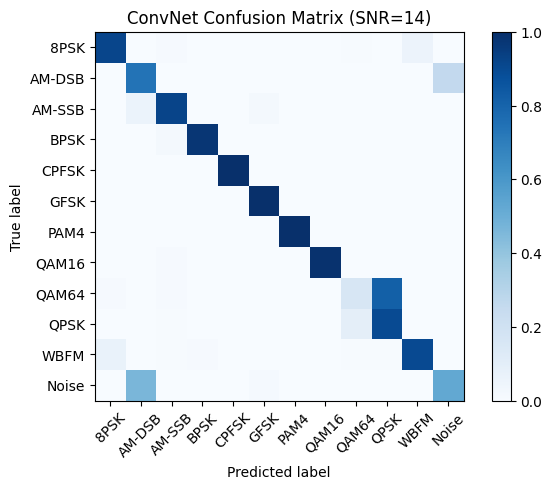

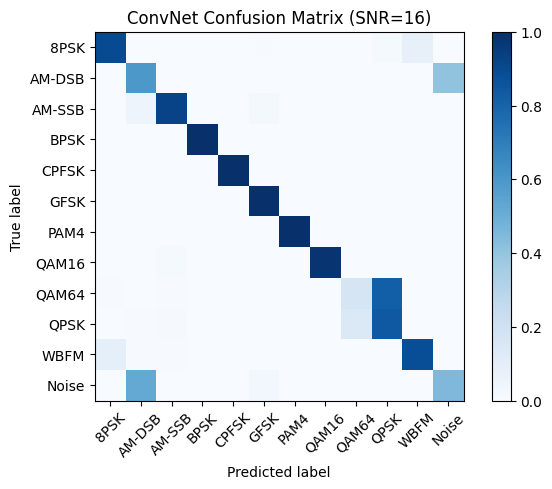

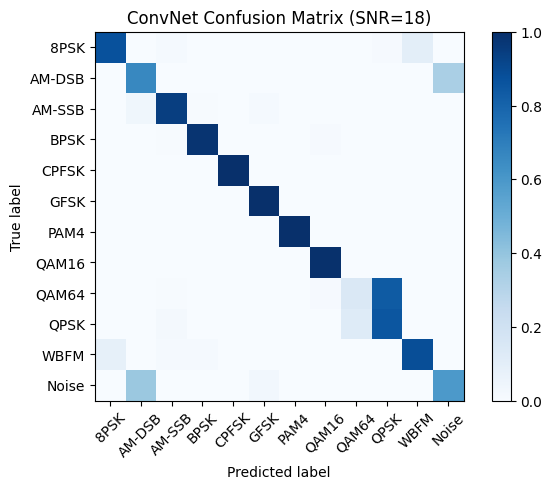

In [93]:
# Plot confusion matrix
acc = {}
for snr in snrs:

    # extract classes @ SNR
    test_SNRs = map(lambda x: int(lbl[x][1]), test_idx)
    test_S = []
    for i in test_SNRs:
      test_S.append(i)
    test_S = np.array(test_S)
    test_X_i = X_test[np.where(test_S == snr)]
    test_Y_i = Y_test[np.where(test_S == snr)]

    # estimate classes
    test_Y_i_hat = model1.predict(test_X_i, batch_size=batch_size)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))

    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("Overall Accuracy for SNR {}: {}".format(snr, cor / (cor+ncor)))
    acc[snr] = 1.0*cor/(cor+ncor)

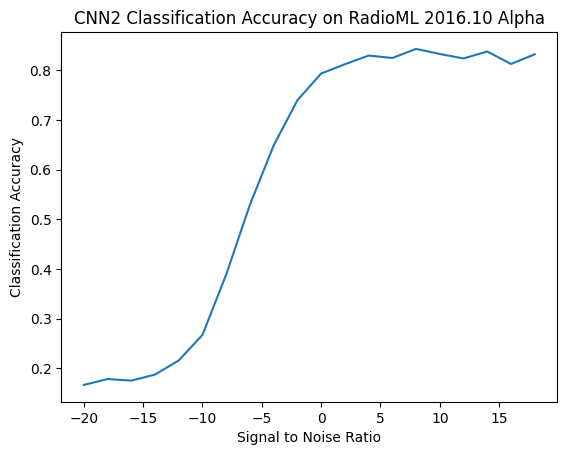

In [94]:
# Plot accuracy curve
plt.plot(snrs, list(map(lambda x: acc[x], snrs)));
plt.xlabel("Signal to Noise Ratio");
plt.ylabel("Classification Accuracy");
plt.title("CNN2 Classification Accuracy on RadioML 2016.10 Alpha");

## 6. Análisis



### Modelo 1:

**Evaluación del modelo:**

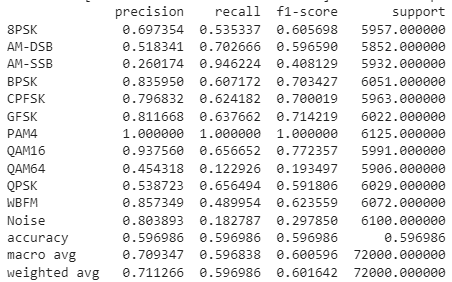

A partir de estas métricas, se pueden eobservar lo siguiente:

- El modelo tiene un accuracy global del 59.7%, lo que indica que puede clasificar correctamente más de la mitad de los casos, pero aún tiene un margen de mejora.
- La clase que mejor se clasifica es PAM4, con una precisión, un recall y un f1-score del 100%. Esto se debe a que esta modulación tiene una forma de onda muy distinta a las demás y es fácil de distinguir por el modelo.
- La clase que peor se clasifica es QAM64, con una precisión del 45.4%, un recall del 12.3% y un f1-score del 19.3%. Esto se debe a que esta modulación tiene una forma de onda muy similar a la de QAM16, y el ruido gaussiano dificulta su diferenciación por el modelo.
- La clase Noise tiene una precisión del 80.4%, lo que indica que el modelo puede identificar correctamente la mayoría de los casos en los que no hay una modulación clara, pero tiene un recall del 18.3%, lo que indica que hay muchos casos en los que el modelo asigna una modulación verdadera cuando en realidad hay ruido. Esto puede deberse a que el nivel de ruido no es suficiente para enmascarar completamente la señal modulada, o a que el modelo no ha aprendido bien los umbrales de decisión entre las clases.
- La clase AM-SSB tiene una precisión muy baja del 26%, pero un recall muy alto del 94.6%. Esto significa que el modelo asigna muchos casos a esta clase, aunque no sean correctos, pero también acierta la mayoría de los casos reales de esta clase. Esto puede deberse a que esta modulación tiene una forma de onda muy variable y el modelo no ha aprendido bien sus características distintivas.
- Las demás clases tienen unas métricas moderadas, con una precisión y un recall entre el 50% y el 85%, y un f1-score entre el 40% y el 77%. Esto indica que el modelo puede clasificar estas modulaciones con un nivel de acierto aceptable, pero también comete algunos errores de confusión entre clases similares.

**Curva de pérdida:**

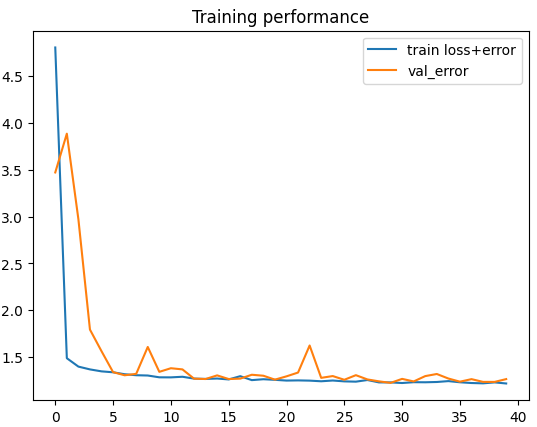

A partir de la curva de pérdida, se puede observar que el modelo aprende rápidamente las características generales de las modulaciones y reduce el error de forma significativa. El modelo alcanza un punto de equilibrio en el que no puede reducir más el error, ya sea porque ha aprendido todo lo posible o además, se detuvo en la época 40 evitando el sobreajuste a los datos de entrenamiento.

Se observa la intersección entre las curvas de entrenamiento y validación, esto indica que el modelo tiene un rendimiento similar en ambos conjuntos, lo que sugiere que no hay sobreajuste ni subajuste. Sin embargo, el nivel de error es relativamente alto, lo que indica que el modelo podría mejorar con más datos o con una arquitectura diferente. El modelo tiene un comportamiento aceptable, pero no óptimo.

**Matriz de confusión:**

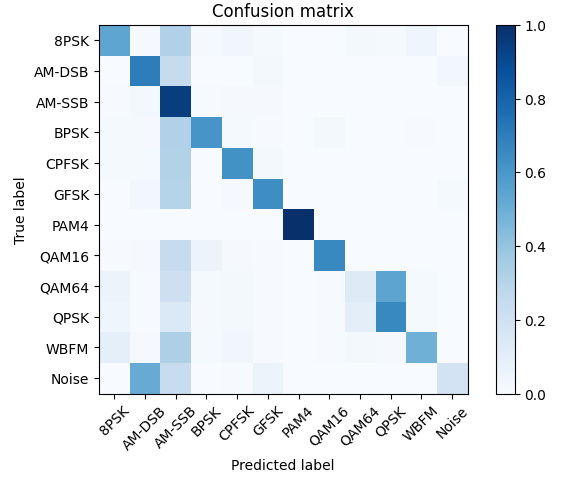

En la matriz de confusión se observa una buena diagonal, es decir, hay un mayor número de casos en los que la predicción coincide con la etiqueta verdadera, y un menor número de casos en los que hay una confusión entre clases.

Se puede decir que el modelo acierta la mayoría de las predicciones de cada clase, lo que se refleja en los valores de precisión y recall. Las clases que tienen los valores más altos en la diagonal son PAM4, BPSK, GFSK y CPFSK Y 8PSK, lo que indica que el modelo puede distinguir bien estas modulaciones de las demás.

Se presentan bloques con valores medios, esto indica que el modelo se equivoca al predecir algunas clases que son similares entre sí o que tienen una forma de onda parecida. Por ejemplo, el modelo confunde AM-SSB con la mayoría de modulaciones excepto PAM4, confunde QAM64 con QPSK, esto se debe a que estas modulaciones tienen una mayor solapamiento espectral o una menor distancia euclidiana entre sus constelaciones, lo que dificulta su diferenciación por el modelo.

En la matriz de confusión se muestra que el modelo tiene una buena capacidad de clasificación de las modulaciones, pero también tiene algunos problemas de confusión entre clases similares, lo que se podría mejorar con más datos o con una extracción de características más adecuada.

### Modelo 2:

**Evaluación del modelo:**

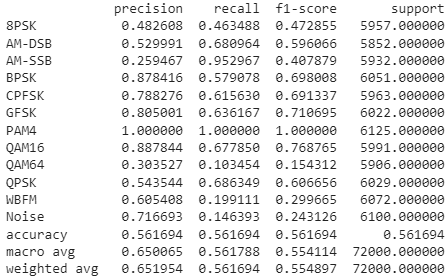

Al igual que en las métricas anteriores, la modulación más fácil de clasificar para el modelo es PAM4, que tiene una precisión y un recall perfectos de 1.000, y la modulación más difícil es QAM64, que tiene una precisión y un recall muy bajos de 0.304 y 0.103, respectivamente. Esto se debe a las mismas razones que se explicaron anteriormente, es decir, la distintividad de la forma de onda de PAM4 y la similitud de la forma de onda de QAM64 con otras modulaciones.

El modelo también tiene problemas para clasificar el ruido gaussiano aleatorio, que tiene una precisión baja de 0.717 y un recall muy bajo de 0.146. Esto se debe a que el ruido no tiene una forma de onda definida y el modelo puede confundirlo con otras modulaciones o ignorarlo por completo.

El modelo tiene un buen desempeño en clasificar otras modulaciones, como BPSK, CPFSK, GFSK, QAM16 y QPSK, que tienen una precisión y un recall superiores al 0.5. Sin embargo, el modelo podría mejorar su capacidad de distinguir estas modulaciones entre sí y del ruido, ya que algunas de ellas tienen formas de onda parecidas o sensibles al ruido. El modelo tiene un desempeño regular en clasificar 8PSK, AM-DSB, AM-SSB y WBFM, que tienen una precisión o un recall inferiores al 0.5. Estas modulaciones pueden tener características que el modelo no puede captar o que se pierden por el efecto del ruido.

**Curva de pérdida:**

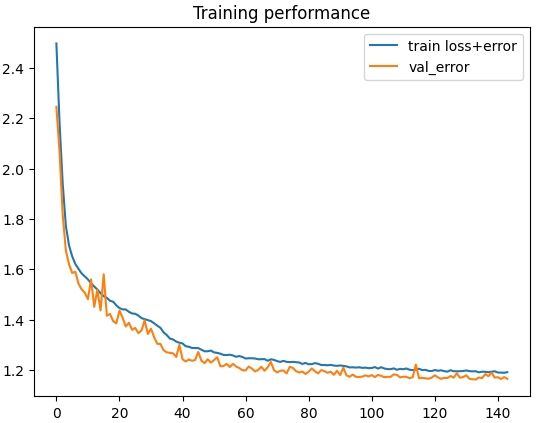

La gráfica muestra que la pérdida y el error de entrenamiento disminuyen a medida que el número de épocas aumenta, lo que significa que el modelo está aprendiendo y mejorando su capacidad de clasificar las modulaciones. Sin embargo, el error de validación no disminuye tan rápido como la pérdida y el error de entrenamiento, lo que puede indicar que el modelo está sobreajustando los datos de entrenamiento, es decir, que está memorizando las características específicas de los datos de entrenamiento y no puede generalizar bien a los datos nuevos o desconocidos.

**Matriz de confusión:**

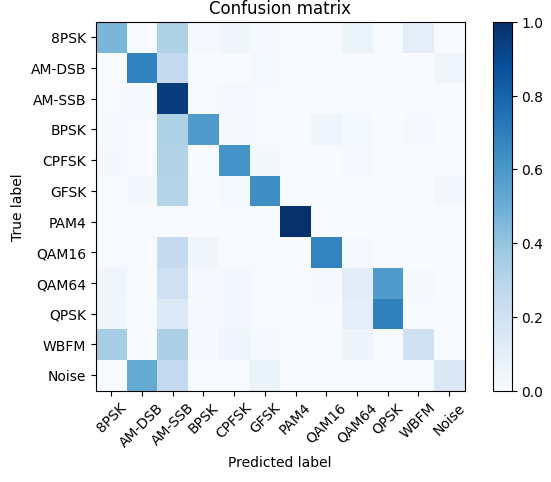

Se observa una buena diagonal, sin embargo, se presentan los mismos problemas que con el otro modelo, en lo referente a la modulación AM-SSB y en el error de clasifiación entre QPSK y QAM64

### Evaluación de los modelos en términos de SNR

Para ambos modelos se encontraron resultados similares, a partir de una Relación Señal-Ruido de 0 dB o mayor se puede apreciar adecuadamente la diagonal en la matriz de confusión, lo que indica que el rendimiento del modelo mejora significativamente cuando la calidad de la señal es relativamente buena. Esto indica que el modelo puede clasificar todas las modulaciones con un nivel de error muy bajo, ya que el ruido apenas afecta a la señal.


A medida que el SNR disminuye, la capacidad del modelo para distinguir entre las clases se ve comprometida, y se observa un rendimiento deficiente, especialmente para SNR en el rango de -20 dB a -8 dB. Esto indica que el modelo no puede clasificar ninguna modulación con un nivel de error muy alto, ya que el ruido enmascara completamente la señal. La única excepción es la modulación PAM4, que tiene una forma de onda muy distinta a las demás y es la única que el modelo puede distinguir con un nivel de error bajo.

EL modelo 1 logra clasificar mejor la modulación QAM64, aunque no tiene tan buena precisión, por otro lado, el modelo 2 clasifica la modulación QAM64 como QPSK, se considera que esto ocurre debido a que ambas modulaciones tienen una forma de onda muy similar que depende de la fase de la señal portadora. Además, ambas modulaciones pueden usar el mismo diagrama de constelación, que es una representación gráfica de los símbolos transmitidos en el plano complejo. Por ejemplo, el QPSK puede usar un diagrama de constelación de 4 puntos, donde cada punto corresponde a un ángulo de fase de 0, 90, 180 o 270 grados. El QAM64 también puede usar un diagrama de constelación de 4 puntos, pero con una amplitud diferente para cada punto. Sin embargo, si el modelo no es capaz de diferenciar la amplitud de los puntos, puede confundir el QAM64 con el QPSK. Esto puede ocurrir si el modelo tiene un umbral de detección muy alto o si el ruido gaussiano aleatorio afecta la amplitud de la señal.

### Evaluación precisión de la clasificación

En ambos modelos se presentan resultados muy similares, donde se observa una tendencia general, ya que la curva muestra que la precisión de la clasificación aumenta a medida que el SNR aumenta, lo que indica que el modelo CNN2 puede reconocer mejor las modulaciones cuando la señal es más fuerte que el ruido.

La curva tiene un punto de inflexión alrededor de SNR = 0. Esto puede deberse a que el modelo CNN2 tiene una zona de confusión cuando la señal y el ruido tienen la misma potencia, lo que dificulta la diferenciación de las modulaciones.

Rango de valores: La curva tiene un rango de valores entre 0.1 y 0.9. Esto implica que el modelo CNN2 tiene un margen de mejora para aumentar su precisión en los casos de bajo SNR o alta complejidad de las modulaciones.


## 7. Conclusiones

- El modelo que mejor se adaptó, fue el modelo 1, debido a que tiene una arquitectura más profunda y compleja con múltiples capas convolucionales y de pooling, seguidas de capas totalmente conectadas. Esto permite que el modelo capture patrones más complejos y abstractos en los datos de entrada, lo cual es beneficioso para tareas de clasificación exigentes. Por otro lado, el segundo modelo tiene una estructura más simple con solo tres capas convolucionales seguidas de capas totalmente conectadas. La capacidad del modelo para aprender características más avanzadas podría verse limitada en comparación con el primer modelo.

- El primer modelo tiene significativamente más parámetros (1648332) en comparación con el segundo modelo (601724). Un mayor número de parámetros proporciona al modelo más capacidad para ajustarse y aprender patrones complejos en los datos de entrenamiento. Aunque un modelo más grande también corre el riesgo de sobreajustarse a los datos de entrenamiento, en este caso, parece que la complejidad adicional beneficia al rendimiento del modelo en la tarea de clasificación.

- El primer modelo utiliza técnicas como Batch Normalization y Dropout, que ayudan a regularizar el modelo durante el entrenamiento. Estas técnicas son útiles para prevenir el sobreajuste y mejorar la generalización a datos no vistos. El segundo modelo también utiliza Dropout, pero no incluye Batch Normalization. La falta de normalización podría afectar la capacidad del modelo para generalizar bien a datos de prueba.

- Aunque ambos modelos comparten la mejora de la precisión con un aumento en la SNR, el Modelo 1 destaca al lograr una mayor precisión en un rango más amplio de condiciones de señal y ruido. Este resultado subraya la importancia de considerar no solo la tendencia general, sino también los detalles específicos de la precisión en diferentes niveles de SNR al evaluar y comparar modelos de clasificación.

- El reconocimiento de modulación a través de redes neuronales convolucionales (CNN) se presenta como una tarea crítica y esencial en el ámbito de las comunicaciones inalámbricas y la radiofrecuencia. La identificación precisa del tipo de modulación de una señal no solo es un desafío técnico, sino que también conlleva una serie de implicaciones prácticas y beneficios sustanciales para los sistemas de comunicación. A continuación, se derivan conclusiones sobre la importancia de una red CNN para llevar a cabo esta tarea:

  - La existencia de diversos tipos de modulación, como BPSK, QPSK, QAM64, entre otros, subraya la complejidad y diversidad de las señales en el entorno de comunicaciones. Una red CNN bien entrenada demuestra ser capaz de adaptarse y distinguir entre estas modulaciones, facilitando la adaptación del receptor al tipo específico de señal recibida.

  - Al identificar con precisión la técnica de modulación utilizada, se pueden aplicar ajustes específicos en el receptor para optimizar la recepción y decodificación de la información transmitida.

  - La capacidad de la red CNN para identificar patrones anómalos en las señales facilita la alerta ante posibles amenazas o perturbaciones en el espectro radioeléctrico.
